STAT 479: Deep Learning (Spring 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/  
GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19

---

In [1]:
%load_ext watermark
%watermark -a 'Zhuoyan_XU' -v -p matplotlib,torch,pandas,numpy,PIL

Zhuoyan_XU 

CPython 3.6.8
IPython 7.4.0

matplotlib 3.0.2
torch 1.0.1
pandas 0.24.2
numpy 1.15.2
PIL 5.4.1


Note that Python's Imaging Library (PIL) can be installed via 

    conda install pillow 

**If you have any installation issues, please don't hesitate to ask via Piazza!**

# HW 3: Training and Tuning a Multilayer Perceptron (40 pts)

**Your task in this homework is to take this existing Multilayer Perceptron implementation and change it to achieve a better performance on the simple dataset I provided.**

---
<font color='darkred'>
For the successfull outcome of this homework:
    
- Your Validation and Test set accuracies should be >= 92%
- Answer the questions at the bottom of this notebook
- Submit this Jupyter Notebook with your modifications as .ipynb and .html file to Canvas (similar to previous homeworks)
</font>
---

**NOTE: Because of the relatively large size (~50 Mb), you need to obtain the dataset from the following link: https://sebastianraschka.com/share/stat479-ss2019/hw3/png-files.zip** (should have very fast download speed). Download this .zip archive and place it into the same directory as your Jupyter Notebook and the .csv files (train.csv, test.csv, valid.csv). Then unzip it. This folder contains ~90,000 images and will take ~300 Mb of hard drive space unzipped.

---

Please read and execute this notebook first to make sure everything works correctly. Then, feel free to make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

In [2]:
import torch
import os
import pandas as pd
import numpy as np
import time
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# NOTE: I actually noticed that this code runs faster on the CPU than on the
# GPU, because the dataset is so small. However, you are encouraged to try
# out training on a GPU, e.g., via Google Colab or Google Cloud engine
# (see Lecture 07)

# Loading the Dataset

The dataset consists of 3 classes:
- Drawings of "birds" (class 0)
- Drawings of "pizzas" (class 1)
- Drawings of "screwdrivers" (class 2)

(The dataset is based on Google Quickdraw: I wrote a script to fetch the images from the database here: https://quickdraw.withgoogle.com/data)

The dataset is very small on purpose so that the training should be relatively fast (but this wouldn't be an ideal DL dataset because of its small size).

In [4]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [8005 7669 6826]


The images are 28x28 dimensional (grayscale).

Some examples:

png-files\bird_000043.png


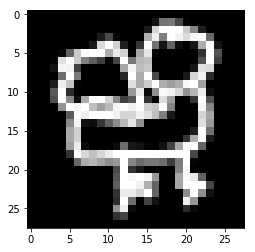

png-files\bird_000107.png


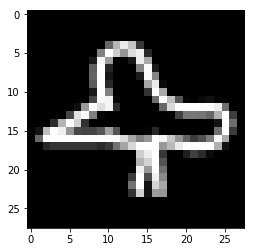

png-files\pizza_000000.png


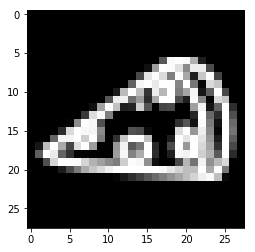

png-files\pizza_000002.png


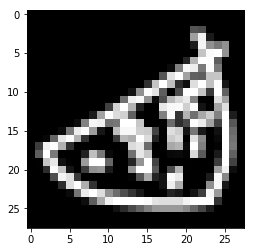

png-files\screwdriver_000001.png


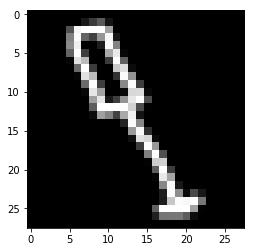

png-files\screwdriver_000012.png


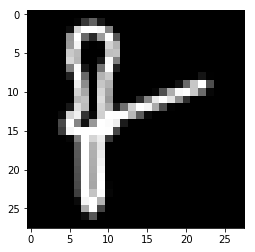

In [5]:
import glob
image_paths = sorted(glob.glob('png-files/*.png'))
for i in (12, 25, 30000, 30001, 60000, 60005):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

---

- The only thing you should change in this section during experimenting is the batch size
- However, it is not required to make changes to the batch size

In [6]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [7]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=150, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=0)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=150,
                          shuffle=False,
                          num_workers=0)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='png-files/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=150,
                         shuffle=False,
                         num_workers=0)

The cell below just checks if the dataset can be loaded correctly.

In [8]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 150
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 150
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [9]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1,num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2,num_hidden_3)
        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE
        out_1 = self.linear_1(x)
        out_1 = torch.relu(out_1)
        out_2 = self.linear_2(out_1)
        out_2 = torch.relu(out_2)
        out_3 = self.linear_3(out_2)
        #out_3 = torch.relu(out_3)
        #out = torch.sigmoid(out_2)
        out = torch.sigmoid(out_3)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=30,
            num_hidden_2=40,
            num_hidden_3=30,
            num_classes=3)

model = model.to(DEVICE)


### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.20)

In [10]:
#################################
### Training
#################################


################################################
# PLEASE DON'T CHANGE THE compute_epoch_loss
# and the compute accuracy functions
###############################################

def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

    
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    


start_time = time.time()
minibatch_cost = []
epoch_cost = []

#################################################################
### NO NEED TO CHANGE ANYTHING BELOW. HOWEVER, YOU CAN CHANGE
### THE NUMBER OF EPOCHS IF YOU LIKE
#################################################################

NUM_EPOCHS = 20 # Please feel free to change

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy = compute_accuracy(model, train_loader)
    valid_accuracy = compute_accuracy(model, valid_loader)
    
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Train Accuracy: %.3f | Validation Accuracy: %.3f' % (train_accuracy, valid_accuracy))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 000/150 | Cost: 1.1041
Epoch: 001/020 | Batch 050/150 | Cost: 1.0967
Epoch: 001/020 | Batch 100/150 | Cost: 0.8593
Epoch: 001/020 Train Cost: 0.6101
Train Accuracy: 76.356 | Validation Accuracy: 76.480
Time elapsed: 0.75 min
Epoch: 002/020 | Batch 000/150 | Cost: 0.6573
Epoch: 002/020 | Batch 050/150 | Cost: 0.6053
Epoch: 002/020 | Batch 100/150 | Cost: 0.5385
Epoch: 002/020 Train Cost: 0.4438
Train Accuracy: 83.298 | Validation Accuracy: 84.520
Time elapsed: 1.47 min
Epoch: 003/020 | Batch 000/150 | Cost: 0.4867
Epoch: 003/020 | Batch 050/150 | Cost: 0.3951
Epoch: 003/020 | Batch 100/150 | Cost: 0.2942
Epoch: 003/020 Train Cost: 0.3418
Train Accuracy: 88.569 | Validation Accuracy: 88.080
Time elapsed: 2.22 min
Epoch: 004/020 | Batch 000/150 | Cost: 0.3371
Epoch: 004/020 | Batch 050/150 | Cost: 0.3965
Epoch: 004/020 | Batch 100/150 | Cost: 0.2079
Epoch: 004/020 Train Cost: 0.3226
Train Accuracy: 88.987 | Validation Accuracy: 88.440
Time elapsed: 3.00 min
Epoch: 0

# Evaluation (No Need To Change Any Code in This Section!)

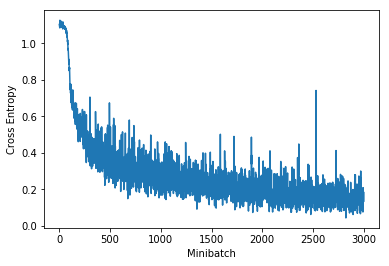

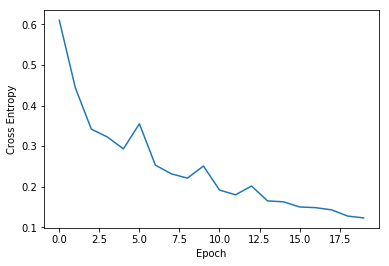

In [11]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [12]:
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Test Accuracy: 92.17


# Conclusions (YOUR ANSWERS REQUIRED)

**1) What is your training, validation, and test accuracy (paste your numbers from above)? Also, do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?**

My training, validation, and test accuracy is 96.302, 92.120 and 92.17. Yes, I have overfitting, since the training accuracy is much higher than validation and test accuracy. I think the number of layers and number of hidden units caused overfitting. I think reduce the number if hidden units and hidden layers can reduce overfitting.

**2) What architectual changes did you make to improve the performance?**

I change the learning rate. And I add two hidden layers meanwhile changing the number of units in the hidden layers. And I change the number of epochs, and the minibatch size.

**3) Assuming you increased the accuracy by 3%, how many more correct predictions did the improved model make in the test set?**

There is 65000 observations in test set totally. Thus, if increase accuracy by 3%, there are $65000 \times 0.03 = 1950$ more correct predictions that improved the model in test set.